# Seamless integration of calibration and application


Relevant PRs:
- Add pulse gate pass #6759, https://github.com/Qiskit/qiskit-terra/pull/6759
- Allow backend cal to export instmap #185, https://github.com/Qiskit/qiskit-experiments/pull/185

## Problem statement

Calibration with Qiskit Pulse:

- T. Alexander et al, *Qiskit Pulse: Programming Quantum Computers Through the Cloud with Pulses*, [arXiv:2004.06755](https://arxiv.org/abs/2004.06755)
- S. Garion et al, *Experimental implementation of non-Clifford interleaved randomized benchmarking with a controlled-S gate*, [arXiv:2007.08532](https://arxiv.org/abs/2007.08532)
- K. Heya and N. Kanazawa, *Cross cross resonance gate*, [arXiv:2103.00024](https://arxiv.org/abs/2103.00024)
- Shun Oomura et al, *Design and application of high-speed and high-precision CV gate on IBM Q OpenPulse system*, [arXiv:2102.06117](https://arxiv.org/abs/2102.06117)

Currently most of research and development with Qiskit Pulse are limited to **gate level** characterization. 

We want to show more capability of our software stack, like below paper.

- John P. T. Stenger et al, *Simulating the dynamics of braiding of Majorana zero modes using an IBM quantum computer*, [arXiv:2012.11660](https://arxiv.org/abs/2012.11660)

## Background

Qiskit Experiment offers new SDK for calibration development. 

**Typical workflow (pseudocode)**
```{r, eval=FALSE,tidy=FALSE}
Declare a backend calibrations: cal
Declare a sequence of experiment: exps = [exp1, exp2, ...]

for each exp do
   run exp, store result in exp_data
   update cal with exp_data
   upload exp_data to resultdb
end do

upload cal to remote data base (to be developped)
```
End-users without knowledge of Qiskit Pulse can run calibration experiment

Qiskit quantum circuit supports [pulse gate](https://qiskit.org/documentation/tutorials/circuits_advanced/05_pulse_gates.html) feature.

```python
qc = QuantumCircuit(2)
qc.cx(0, 1)
qc.add_calibration(CXGate, (0, 1), my_custom_cx_gate)
```

Pulse programming is no longer mandatory to use custom gate instruction.

## What to be implemented


A transpiler pass, that
  - loads `InstructionScheduleMap` from the backend, and
  - requests gate schedule to the map, and
  - attachs a pulse gate to the transpiled circuit if the pass finds an user provided entry.

This demo shows implementation of **Richardson extrapolation** for chemistry applications.

Currently we need to manage these things to apply custom calibration :(
- Basis_gates
- Coupling_map
- Instruction schedule map
- Qubit and cavity LO frequencies

In [1]:
import warnings
warnings.filterwarnings('ignore')

import datetime
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy import signal
from qiskit import IBMQ, pulse, circuit
from qiskit.visualization.pulse_v2 import IQXDebugging
from qiskit.result import Result, marginal_counts
from qiskit.providers.ibmq.utils.json_encoder import IQXJsonEncoder
from qiskit.providers.ibmq.utils.json_decoder import decode_result

class DateTimeEncoder(json.JSONEncoder):

    def default(self, obj):
        if isinstance(obj, (datetime.datetime, datetime.date, datetime.time)):
            return obj.isoformat()
        elif isinstance(obj, datetime.timedelta):
            return (datetime.datetime.min + obj).time().isoformat()

        return super(DateTimeEncoder, self).default(obj)

IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

### Configurations

In [2]:
backend = IBMQ.get_provider("ibm-q-internal", "deployed", "default").get_backend("ibmq_lima")

In [3]:
qubits = 0, 1

durs1 = 160, 880
durs2 = 320, 1760

In [4]:
basename = "lima_20210813"

### Utils

In [5]:
def get_params(sx_dur, cx_dur, sigma_r=4, cx_sigma=64, cx_risefall=2):
    return {
        "sx0": {"duration": sx_dur, "amp": 0., "sigma": sx_dur/sigma_r, "beta": 0.},
        "sx1": {"duration": sx_dur, "amp": 0., "sigma": sx_dur/sigma_r, "beta": 0.},
        "ecr": {"duration": cx_dur, "amp": 0., "phase": 0., "sigma": cx_sigma, "risefall_sigma_ratio": cx_risefall}
    }

In [6]:
def rough_amp(qubits, amps, cals):
    amp = circuit.Parameter("amp")
    
    with pulse.build(backend, default_alignment="sequential") as sched:
        with pulse.align_left():
            for ind, q in enumerate(qubits):
                sxcal = cals[f"sx{ind}"].copy()
                sxcal["amp"] = amp
                pulse.play(pulse.Drag(**sxcal), pulse.drive_channel(q))
        pulse.measure(qubits, [pulse.MemorySlot(ind) for ind in range(len(qubits))])
    
    return [sched.assign_parameters({amp: amp_val}, inplace=False) for amp_val in amps]


def rough_amp_cr(qubits, amps, cals):
    amp = circuit.Parameter("amp")
    qc, qt = qubits
    
    with pulse.build(backend, default_alignment="sequential") as sched:
        sxcal = cals["sx0"]
        crcal = cals["ecr"].copy()
        crcal["amp"] = amp * np.exp(1j*crcal.pop("phase", 0.))
        u_chan = pulse.control_channels(*qubits)[0]
        
        pulse.play(pulse.GaussianSquare(**crcal), u_chan)
        pulse.play(pulse.Drag(**sxcal), pulse.drive_channel(qc))
        pulse.play(pulse.Drag(**sxcal), pulse.drive_channel(qc))
        with pulse.phase_offset(np.pi, u_chan):
            pulse.play(pulse.GaussianSquare(**crcal), u_chan)        
        pulse.measure([qt], [pulse.MemorySlot(0)])
    
    return [sched.assign_parameters({amp: amp_val}, inplace=False) for amp_val in amps]


def phase_cr(qubits, phases, cals):
    phase = circuit.Parameter("phase")
    qc, qt = qubits
    
    with pulse.build(backend, default_alignment="sequential") as sched:
        sxcal_c = cals["sx0"]
        sxcal_t = cals["sx1"]
        crcal = cals["ecr"].copy()
        crcal.pop("phase")
        crcal["amp"] *= np.exp(1j*phase)
        u_chan = pulse.control_channels(*qubits)[0]
        
        pulse.play(pulse.GaussianSquare(**crcal), u_chan)
        pulse.play(pulse.Drag(**sxcal_c), pulse.drive_channel(qc))
        pulse.play(pulse.Drag(**sxcal_c), pulse.drive_channel(qc))
        with pulse.phase_offset(np.pi, u_chan):
            pulse.play(pulse.GaussianSquare(**crcal), u_chan)
        pulse.play(pulse.Drag(**sxcal_t), pulse.drive_channel(qt))
        pulse.measure([qt], [pulse.MemorySlot(0)])
    
    return [sched.assign_parameters({phase: val}, inplace=False) for val in phases]    


def fine_amp(qubits, delta_amps, n_rep, cals):
    delta_amp = circuit.Parameter("delta_amp")
    
    with pulse.build(backend=backend, default_alignment="sequential") as sched_p:
        with pulse.align_left():
            for ind, q in enumerate(qubits):
                sxcal = cals[f"sx{ind}"].copy()
                sxcal["amp"] += delta_amp
                sx_pulse = pulse.Drag(**sxcal)
                for _ in range(4 * n_rep):
                    pulse.play(sx_pulse, pulse.drive_channel(q))
                pulse.play(sx_pulse, pulse.drive_channel(q))
        pulse.measure(qubits, [pulse.MemorySlot(ind) for ind in range(len(qubits))])

    with pulse.build(backend=backend, default_alignment="sequential") as sched_m:
        with pulse.align_left():
            for ind, q in enumerate(qubits):
                sxcal = cals[f"sx{ind}"].copy()
                sxcal["amp"] += delta_amp
                sx_pulse = pulse.Drag(**sxcal)
                with pulse.phase_offset(np.pi, pulse.drive_channel(q)):
                    for _ in range(4 * n_rep):
                        pulse.play(sx_pulse, pulse.drive_channel(q))
                pulse.play(sx_pulse, pulse.drive_channel(q))
        pulse.measure(qubits, [pulse.MemorySlot(ind) for ind in range(len(qubits))])
    
    sched_p_assigned = [sched_p.assign_parameters({delta_amp: val}, inplace=False) for val in delta_amps]
    sched_m_assigned = [sched_m.assign_parameters({delta_amp: val}, inplace=False) for val in delta_amps]
    
    return sched_p_assigned + sched_m_assigned    


def fine_amp_cr(qubits, delta_amps, n_rep, cals):
    delta_amp = circuit.Parameter("delta_amp")
    qc, qt = qubits
    sxcal_c = cals["sx0"]
    sxcal_t = cals["sx1"]
    
    crcal = cals["ecr"].copy()
    _amp = (crcal["amp"] + delta_amp) * np.exp(1j*crcal.pop("phase", 0.))
    crcal["amp"] = _amp    
    
    with pulse.build(backend, default_alignment="sequential") as sched_p:
        u_chan = pulse.control_channels(*qubits)[0]
        
        for _ in range (4 * n_rep):
            pulse.play(pulse.GaussianSquare(**crcal), u_chan)
            pulse.play(pulse.Drag(**sxcal_c), pulse.drive_channel(qc))
            pulse.play(pulse.Drag(**sxcal_c), pulse.drive_channel(qc))
            with pulse.phase_offset(np.pi, u_chan):
                pulse.play(pulse.GaussianSquare(**crcal), u_chan)
            pulse.play(pulse.Drag(**sxcal_c), pulse.drive_channel(qc))
            pulse.play(pulse.Drag(**sxcal_c), pulse.drive_channel(qc))
        pulse.play(pulse.Drag(**sxcal_t), pulse.drive_channel(qt))
        pulse.measure([qt], [pulse.MemorySlot(0)])

    with pulse.build(backend=backend, default_alignment="sequential") as sched_m:
        u_chan = pulse.control_channels(*qubits)[0]
        
        for _ in range (4 * n_rep):
            with pulse.phase_offset(np.pi, u_chan):
                pulse.play(pulse.GaussianSquare(**crcal), u_chan)
            pulse.play(pulse.Drag(**sxcal_c), pulse.drive_channel(qc))
            pulse.play(pulse.Drag(**sxcal_c), pulse.drive_channel(qc))
            pulse.play(pulse.GaussianSquare(**crcal), u_chan)
            pulse.play(pulse.Drag(**sxcal_c), pulse.drive_channel(qc))
            pulse.play(pulse.Drag(**sxcal_c), pulse.drive_channel(qc))
        pulse.play(pulse.Drag(**sxcal_t), pulse.drive_channel(qt))
        pulse.measure([qt], [pulse.MemorySlot(0)])
    
    sched_p_assigned = [sched_p.assign_parameters({delta_amp: val}, inplace=False) for val in delta_amps]
    sched_m_assigned = [sched_m.assign_parameters({delta_amp: val}, inplace=False) for val in delta_amps]
    
    return sched_p_assigned + sched_m_assigned


def fine_beta(qubits, delta_betas, n_rep, cals):
    delta_beta = circuit.Parameter("beta")
    
    with pulse.build(backend=backend, default_alignment="sequential") as sched_p:
        with pulse.align_left():
            for ind, q in enumerate(qubits):
                sxcal = cals[f"sx{ind}"].copy()
                sxcal["beta"] += delta_beta
                sx_pulse = pulse.Drag(**sxcal)
                pulse.play(sx_pulse, pulse.drive_channel(q))
                for _ in range(n_rep):
                    pulse.play(sx_pulse, pulse.drive_channel(q))
                    with pulse.phase_offset(np.pi, pulse.drive_channel(q)):
                        pulse.play(sx_pulse, pulse.drive_channel(q))
                with pulse.phase_offset(0.5 * np.pi, pulse.drive_channel(q)):
                    pulse.play(sx_pulse, pulse.drive_channel(q))
        pulse.measure(qubits, [pulse.MemorySlot(ind) for ind in range(len(qubits))])

    with pulse.build(backend=backend, default_alignment="sequential") as sched_m:
        with pulse.align_left():
            for ind, q in enumerate(qubits):
                sxcal = cals[f"sx{ind}"].copy()
                sxcal["beta"] += delta_beta
                sx_pulse = pulse.Drag(**sxcal)
                pulse.play(sx_pulse, pulse.drive_channel(q))
                for _ in range(n_rep):
                    pulse.play(sx_pulse, pulse.drive_channel(q))
                    with pulse.phase_offset(np.pi, pulse.drive_channel(q)):
                        pulse.play(sx_pulse, pulse.drive_channel(q))
                with pulse.phase_offset(-0.5 * np.pi, pulse.drive_channel(q)):
                    pulse.play(sx_pulse, pulse.drive_channel(q))
        pulse.measure(qubits, [pulse.MemorySlot(ind) for ind in range(len(qubits))])
    
    sched_p_assigned = [sched_p.assign_parameters({delta_beta: val}, inplace=False) for val in delta_betas]
    sched_m_assigned = [sched_m.assign_parameters({delta_beta: val}, inplace=False) for val in delta_betas]
    
    return sched_p_assigned + sched_m_assigned

In [7]:
def run(scheds, exp_name, **options):
    fpstr = f"./{basename}_{exp_name}.json"
    if os.path.isfile(fpstr):
        with open(fpstr, "r") as fp:
            cache = json.load(fp)
        return Result.from_dict(cache)
    
    job = backend.run(scheds, **options)
    result = job.result(timeout=3600)    
    with open(fpstr, "w") as fp:
        json.dump(result.to_dict(), fp, cls=DateTimeEncoder)
    return result

def get_expval(result, ind, shots):
    res = []
    for circ_res in result.get_counts():
        counts = 0
        for key, count in circ_res.items():
            if key[::-1][ind] == "1":
                counts += count
        res.append(counts/shots)
    
    return 2 * (0.5 - np.asarray(res, dtype=float))

def find_cross_point(xdata, ydata1, ydata2, n=4, filt_dim=5):
    ydata1 = signal.savgol_filter(ydata1, filt_dim, 1)
    ydata2 = signal.savgol_filter(ydata2, filt_dim, 1)
    
    cross_points = xdata[1:][np.diff(np.sign(ydata1 - ydata2)) != 0]
    main_cross = cross_points[np.argmin(np.abs(cross_points))]
    idx = np.argmin(np.abs(xdata - main_cross))

    x_reduced = xdata[idx-n:idx+n]
    y1_reduced = ydata1[idx-n:idx+n]
    y2_reduced = ydata2[idx-n:idx+n]

    p1 = np.polyfit(x_reduced, y1_reduced, 1)
    p2 = np.polyfit(x_reduced, y2_reduced, 1)

    cross_opt = (p2[1] - p1[1]) / (p1[0] - p2[0])
    
    return cross_opt

### Run calibration

In [8]:
params1 = get_params(*durs1)
params2 = get_params(*durs2)

single qubit gate

In [9]:
amps = np.linspace(-0.2, 0.2, 31)

result = run(
    rough_amp(qubits, amps, params1) + rough_amp(qubits, amps, params2),
    "rough_amp",
    shots=128
)

qubit 0 amp = 0.06190683049046956
qubit 0 amp = 0.030891625013434336
qubit 1 amp = 0.07819842804698184
qubit 1 amp = 0.039139513770162594


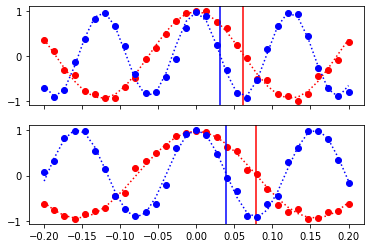

In [10]:
fig, axs = plt.subplots(2, 1, sharex=True)

fit_func = lambda x, a, b, f: a * np.cos(2 * np.pi * f * x) + b
bounds = (0, -1, 0), (1, 1, np.inf)

for qind, ax in enumerate(axs):
    expvals = np.split(get_expval(result, qind, 128), 2)
    for expval, params_dict, color in zip(expvals, (params1, params2), ("r", "b")):
        # freq init guess
        fft_data = np.fft.fft(expval - np.average(expval))
        freqs = np.fft.fftfreq(len(amps), amps[1] - amps[0])
        positive_freqs = freqs[freqs >= 0]
        positive_fft_data = fft_data[freqs >= 0]
        f0 = positive_freqs[np.argmax(np.abs(positive_fft_data))]
        # fit
        pcov, _ = opt.curve_fit(fit_func, amps, expval, p0=[1, 0, f0], bounds=bounds)
        # plot
        ax.plot(amps, expval, "o", color=color)
        ax.plot(amps, fit_func(amps, *pcov), ":", color=color)
        hpi_amp = 1/(2*pcov[2])/2
        ax.axvline(hpi_amp, color=color)
        # update parameters
        print(f"qubit {qind} amp = {hpi_amp}")
        params_dict[f"sx{qind}"]["amp"] = hpi_amp

In [11]:
delta_amps = np.linspace(-0.02, 0.02, 21)

result = run(
    fine_amp(qubits, delta_amps, 1, params1) + fine_amp(qubits, delta_amps, 1, params2),
    "fine_amp1",
    shots=128
)

qubit 0, Δamp = -0.0012949803759553817
qubit 0, Δamp = -0.0005709589041095901
qubit 1, Δamp = -0.0012403433476394854
qubit 1, Δamp = -0.00030834160873882953


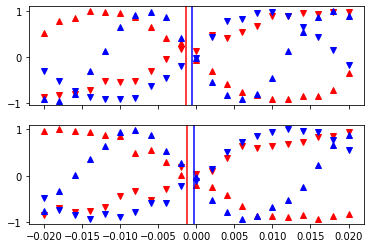

In [12]:
fig, axs = plt.subplots(2, 1, sharex=True)

for qind, ax in enumerate(axs):
    expvals = np.split(get_expval(result, qind, 128), 2)
    for expval, params_dict, color in zip(expvals, (params1, params2), ("red", "blue")):
        yp, ym = np.split(expval, 2)
        p = find_cross_point(delta_amps, yp, ym)
        # plot
        ax.plot(delta_amps, yp, "^", color=color)
        ax.plot(delta_amps, ym, "v", color=color)
        ax.axvline(p, color=color)
        # update parameters
        print(f"qubit {qind}, Δamp = {p}")
        params_dict[f"sx{qind}"]["amp"] += p

In [13]:
delta_betas = np.linspace(-10, 10, 21)

result = run(
    fine_beta(qubits, delta_betas, 3, params1) + fine_beta(qubits, delta_betas, 3, params2),
    "fine_beta1",
    shots=1024
)

qubit 0, Δbeta = 0.6771684682309518
qubit 0, Δbeta = 0.6236837408531145
qubit 1, Δbeta = -1.5364380899500278
qubit 1, Δbeta = -2.5114264985943593


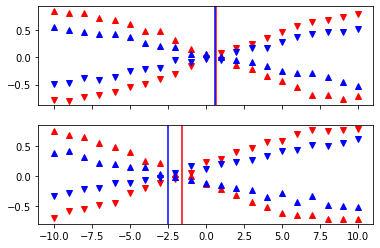

In [14]:
fig, axs = plt.subplots(2, 1, sharex=True)

for qind, ax in enumerate(axs):
    expvals = np.split(get_expval(result, qind, 1024), 2)
    for expval, params_dict, color in zip(expvals, (params1, params2), ("red", "blue")):
        yp, ym = np.split(expval, 2)
        p = find_cross_point(delta_betas, yp, ym)
        # plot
        ax.plot(delta_betas, yp, "^", color=color)
        ax.plot(delta_betas, ym, "v", color=color)
        ax.axvline(p, color=color)
        # update parameters
        print(f"qubit {qind}, Δbeta = {p}")
        params_dict[f"sx{qind}"]["beta"] += p

In [15]:
delta_amps = np.linspace(-0.005, 0.005, 21)

result = run(
    fine_amp(qubits, delta_amps, 2, params1) + fine_amp(qubits, delta_amps, 2, params2),
    "fine_amp2",
    shots=128
)

qubit 0, amp = 0.00037509025270758133
qubit 0, amp = 0.00019657724329324723
qubit 1, amp = -8.221291602380456e-05
qubit 1, amp = -0.00010003758456527213


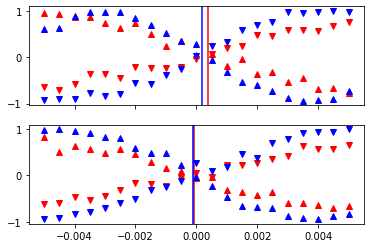

In [16]:
fig, axs = plt.subplots(2, 1, sharex=True)

for qind, ax in enumerate(axs):
    expvals = np.split(get_expval(result, qind, 128), 2)
    for expval, params_dict, color in zip(expvals, (params1, params2), ("red", "blue")):
        yp, ym = np.split(expval, 2)
        p = find_cross_point(delta_amps, yp, ym)
        # plot
        ax.plot(delta_amps, yp, "^", color=color)
        ax.plot(delta_amps, ym, "v", color=color)
        ax.axvline(p, color=color)
        # update parameters
        print(f"qubit {qind}, amp = {p}")
        params_dict[f"sx{qind}"]["amp"] += p

two qubit gate

In [17]:
amps = np.linspace(-0.8, 0.8, 51)

result = run(
    rough_amp_cr(qubits, amps, params1) + rough_amp_cr(qubits, amps, params2),
    "rough_amp_cr",
    shots=128
)

ECR amp = 0.21256288874575127
ECR amp = 0.09478450688936299


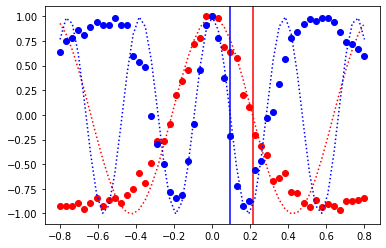

In [18]:
fit_func = lambda x, a, b, f: a * np.cos(2 * np.pi * f * x) + b
bounds = (0, -1, 0), (1, 1, np.inf)

expvals = np.split(get_expval(result, 0, 128), 2)
for expval, params_dict, color in zip(expvals, (params1, params2), ("r", "b")):
    # freq init guess
    fft_data = np.fft.fft(expval - np.average(expval))
    freqs = np.fft.fftfreq(len(amps), amps[1] - amps[0])
    positive_freqs = freqs[freqs >= 0]
    positive_fft_data = fft_data[freqs >= 0]
    f0 = positive_freqs[np.argmax(np.abs(positive_fft_data))]
    # fit
    pcov, _ = opt.curve_fit(
        fit_func,
        amps, 
        expval,
        p0=[1, 0, f0], 
        bounds=bounds,
        sigma=1/(1-np.abs(amps)) - 0.99,
        absolute_sigma=True,
    )
    # plot
    plt.plot(amps, expval, "o", color=color)
    plt.plot(amps, fit_func(amps, *pcov), ":", color=color)
    hpi_amp = 1/(2*pcov[2])/2
    plt.axvline(hpi_amp, color=color)
    # update parameters
    print(f"ECR amp = {hpi_amp}")
    params_dict["ecr"]["amp"] = hpi_amp

In [19]:
phases = np.linspace(-np.pi, np.pi, 31)

result = run(
    phase_cr(qubits, phases, params1) + phase_cr(qubits, phases, params2),
    "rough_phase_cr",
    shots=128
)

ECR phase = -1.5936465736763337
ECR phase = -1.700260556225036


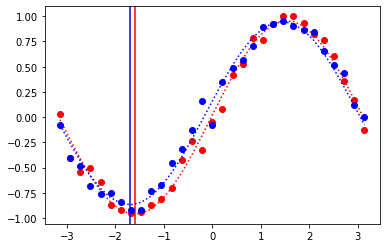

In [20]:
fit_func = lambda x, a, b, phi: a * np.cos(x - phi) + b
bounds = (0, -1, -np.pi), (1, 1, np.pi)

expvals = np.split(get_expval(result, 0, 128), 2)
for expval, params_dict, color in zip(expvals, (params1, params2), ("r", "b")):
    # fit
    pcov, _ = opt.curve_fit(fit_func, phases, expval, p0=[1, 0, 0], bounds=bounds)
    # plot
    plt.plot(phases, expval, "o", color=color)
    plt.plot(phases, fit_func(phases, *pcov), ":", color=color)
    cr_phase = pcov[2] + np.pi
    if cr_phase > np.pi:
        cr_phase -= 2 * np.pi
    plt.axvline(cr_phase, color=color)
    # update parameters
    print(f"ECR phase = {cr_phase}")
    params_dict["ecr"]["phase"] = cr_phase

In [21]:
delta_amps = np.linspace(-0.05, 0.05, 21)

result = run(
    fine_amp_cr(qubits, delta_amps, 1, params1) + fine_amp_cr(qubits, delta_amps, 1, params2),
    "fine_amp_cr",
    shots=128
)

ECR Δamp = -0.013319767441860463
ECR Δamp = -0.011817283950617284


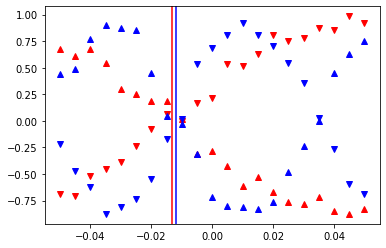

In [22]:
expvals = np.split(get_expval(result, 0, 128), 2)
for expval, params_dict, color in zip(expvals, (params1, params2), ("red", "blue")):
    yp, ym = np.split(expval, 2)
    p = find_cross_point(delta_amps, yp, ym)
    # plot
    plt.plot(delta_amps, yp, "^", color=color)
    plt.plot(delta_amps, ym, "v", color=color)
    plt.axvline(p, color=color)
    # update parameters
    print(f"ECR Δamp = {p}")
    params_dict[f"ecr"]["amp"] += p

In [23]:
params1

{'sx0': {'duration': 160,
  'amp': 0.060986940367221756,
  'sigma': 40.0,
  'beta': 0.6771684682309518},
 'sx1': {'duration': 160,
  'amp': 0.07687587178331853,
  'sigma': 40.0,
  'beta': -1.5364380899500278},
 'ecr': {'duration': 880,
  'amp': 0.1992431213038908,
  'phase': -1.5936465736763337,
  'sigma': 64,
  'risefall_sigma_ratio': 2}}

In [24]:
params2

{'sx0': {'duration': 320,
  'amp': 0.030517243352617993,
  'sigma': 80.0,
  'beta': 0.6236837408531145},
 'sx1': {'duration': 320,
  'amp': 0.03873113457685849,
  'sigma': 80.0,
  'beta': -2.5114264985943593},
 'ecr': {'duration': 1760,
  'amp': 0.0829672229387457,
  'phase': -1.700260556225036,
  'sigma': 64,
  'risefall_sigma_ratio': 2}}

### Prepare backend calibration manager

In [25]:
from qiskit_experiments.calibration_management import BackendCalibrations
from qiskit_experiments.calibration_management.parameter_value import ParameterValue
from datetime import datetime
import pandas as pd

In [26]:
cal_manager = BackendCalibrations(backend=backend)

Manually populate parameters for now. Full calibration chain is not supported by v0.1.

In [27]:
# add sx schedule
sx_amp = circuit.Parameter("amp")
sx_dur = circuit.Parameter("τ")
sx_beta = circuit.Parameter("β")
sx_sigma = circuit.Parameter("σ")
ch_d = pulse.DriveChannel(circuit.Parameter("ch0"))

with pulse.build(name="sx") as sx_sched:
    pulse.play(
        pulse.Drag(duration=sx_dur, amp=sx_amp, sigma=sx_sigma, beta=sx_beta), 
        ch_d
    )

cal_manager.add_schedule(sx_sched)

In [28]:
# parameters for ecr
ecr_amp = circuit.Parameter("amp")
ecr_phase = circuit.Parameter("θ")
ecr_dur = circuit.Parameter("τ")
ecr_sigma = circuit.Parameter("σ")
ch_u = backend.configuration().control(qubits)[0]

with pulse.build(name="ecr", default_alignment="sequential") as ecr_sched:
    with pulse.phase_offset(ecr_phase, ch_u):
        pulse.play(
            pulse.GaussianSquare(duration=ecr_dur, amp=ecr_amp, sigma=ecr_sigma, risefall_sigma_ratio=2), 
            ch_u
        )
        pulse.call(cal_manager.get_template("sx", qubits=(qubits[0], )))
        pulse.call(cal_manager.get_template("sx", qubits=(qubits[0], )))
        pulse.play(
            pulse.GaussianSquare(duration=ecr_dur, amp=-ecr_amp, sigma=ecr_sigma, risefall_sigma_ratio=2), 
            ch_u
        )

cal_manager.add_schedule(ecr_sched)

Add parameters

In [29]:
for ind, param in enumerate([params1, params2]):
    group = ind + 1
    
    # sx
    for qind in qubits:
        cal_manager.add_parameter_value(
            value=ParameterValue(value=param[f"sx{qind}"]["duration"], date_time=datetime.now(), group=f"sf{group}"),
            param=sx_dur,
            qubits=qind,
            schedule="sx",
        )
        cal_manager.add_parameter_value(
            value=ParameterValue(value=param[f"sx{qind}"]["amp"], date_time=datetime.now(), group=f"sf{group}"),
            param=sx_amp,
            qubits=qind,
            schedule="sx",
        )
        cal_manager.add_parameter_value(
            value=ParameterValue(value=param[f"sx{qind}"]["sigma"], date_time=datetime.now(), group=f"sf{group}"),
            param=sx_sigma,
            qubits=qind,
            schedule="sx",
        )
        cal_manager.add_parameter_value(
            value=ParameterValue(value=param[f"sx{qind}"]["beta"], date_time=datetime.now(), group=f"sf{group}"),
            param=sx_beta,
            qubits=qind,
            schedule="sx",
        )
        cal_manager.add_parameter_value(
            value=ParameterValue(value=qind, date_time=datetime.now(), group=f"sf{group}"),
            param=ch_d,
            qubits=qind,
            schedule="sx",
        )
    # ecr
    cal_manager.add_parameter_value(
        value=ParameterValue(value=param["ecr"]["duration"], date_time=datetime.now(), group=f"sf{group}"),
        param=ecr_dur,
        qubits=qubits,
        schedule="ecr",
    )
    cal_manager.add_parameter_value(
        value=ParameterValue(value=param["ecr"]["amp"], date_time=datetime.now(), group=f"sf{group}"),
        param=ecr_amp,
        qubits=qubits,
        schedule="ecr",
    )
    cal_manager.add_parameter_value(
        value=ParameterValue(value=param["ecr"]["phase"], date_time=datetime.now(), group=f"sf{group}"),
        param=ecr_phase,
        qubits=qubits,
        schedule="ecr",
    )
    cal_manager.add_parameter_value(
        value=ParameterValue(value=param["ecr"]["sigma"], date_time=datetime.now(), group=f"sf{group}"),
        param=ecr_sigma,
        qubits=qubits,
        schedule="ecr",
    )
    cal_manager.add_parameter_value(
        value=ParameterValue(value=qubits[0], date_time=datetime.now(), group=f"sf{group}"),
        param=ch_d,
        qubits=qubits[0],
        schedule="ecr",
    )    

Calibrated parameters

In [30]:
df = pd.DataFrame(cal_manager.parameters_table())

In [31]:
df[df["schedule"].notna()].sort_values(["group", "schedule"])

,value,date_time,valid,exp_id,group,qubits,parameter,schedule
15,64.000000,2021-08-13 20:43:24.660958,True,None,sf1,"(0, 1)",σ,ecr
22,0.199243,2021-08-13 20:43:24.660830,True,None,sf1,"(0, 1)",amp,ecr
28,-1.593647,2021-08-13 20:43:24.660864,True,None,sf1,"(0, 1)",θ,ecr
32,0.000000,2021-08-13 20:43:24.660991,True,None,sf1,"(0,)",DriveChannel(ch0),ecr
34,880.000000,2021-08-13 20:43:24.660808,True,None,sf1,"(0, 1)",τ,ecr
0,0.000000,2021-08-13 20:43:24.660565,True,None,sf1,"(0,)",DriveChannel(ch0),sx
2,-1.536438,2021-08-13 20:43:24.660741,True,None,sf1,"(1,)",β,sx
4,160.000000,2021-08-13 20:43:24.660611,True,None,sf1,"(1,)",τ,sx
7,0.060987,2021-08-13 20:43:24.660435,True,None,sf1,"(0,)",amp,sx
12,160.000000,2021-08-13 20:43:24.660331,True,None,sf1,"(0,)",τ,sx


In [32]:
df.query("schedule == 'ecr' and parameter in ['amp', 'τ']").sort_values(["parameter"])

,value,date_time,valid,exp_id,group,qubits,parameter,schedule
22,0.199243,2021-08-13 20:43:24.660830,True,None,sf1,"(0, 1)",amp,ecr
23,0.082967,2021-08-13 20:43:24.661544,True,None,sf2,"(0, 1)",amp,ecr
34,880.000000,2021-08-13 20:43:24.660808,True,None,sf1,"(0, 1)",τ,ecr
35,1760.000000,2021-08-13 20:43:24.661525,True,None,sf2,"(0, 1)",τ,ecr


Compare two calibrations

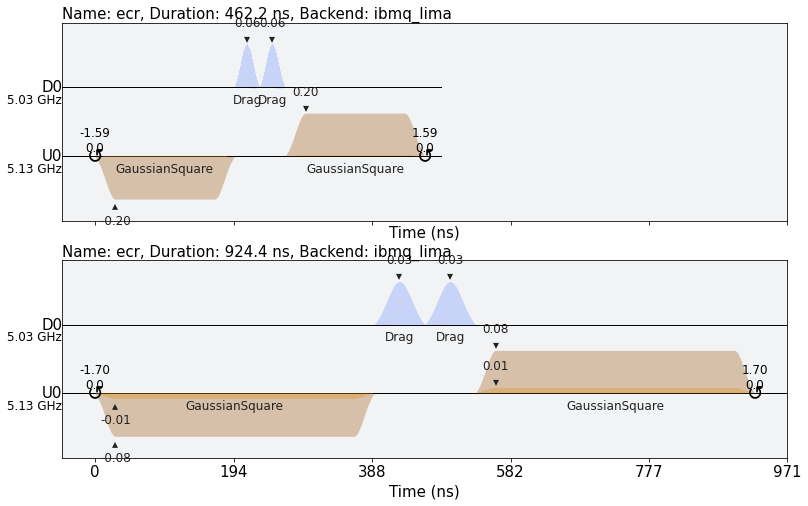

In [33]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(13, 8))

cal_manager.get_schedule("ecr", qubits=qubits, group="sf1").draw(backend=backend, axis=axs[0], style=IQXDebugging(**{"formatter.margin.left_percent": 0.1}))
cal_manager.get_schedule("ecr", qubits=qubits, group="sf2").draw(backend=backend, axis=axs[1], style=IQXDebugging())

### Export backend

Persona and usecase: If you are an application researcher, you can load `cal_manager` from the shared data base. Your collaborator may maintain the calibration for you. So you just need to get backend from a calibration instance, rather than the provider.

In [34]:
gates_to_output = {"sx": [0, 1], "ecr": [(0, 1)]}

In [35]:
sf1_backend = cal_manager.export_backend(
    outputs=gates_to_output,
    basis_gates=["sx", "rz", "ecr"],
    coupling_map=[[0, 1]],
    group="sf1",
)

In [36]:
sf2_backend = cal_manager.export_backend(
    outputs=gates_to_output,
    basis_gates=["sx", "rz", "ecr"],
    coupling_map=[[0, 1]],
    group="sf2",
)

Check exported backend

In [37]:
sf1_backend.configuration().basis_gates

['sx', 'rz', 'ecr']

In [38]:
sf1_backend.configuration().coupling_map

[[0, 1]]

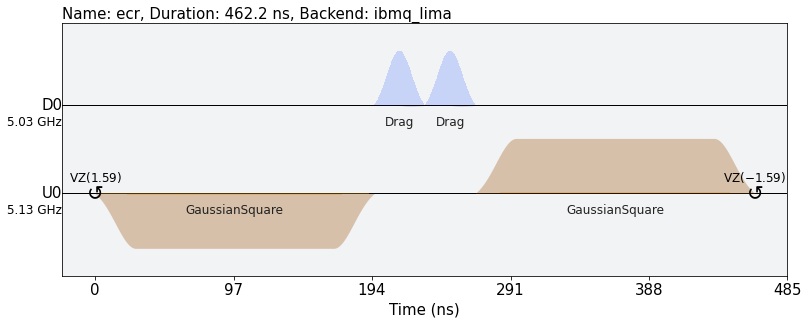

In [39]:
ecr_sched_sf1 = sf1_backend.defaults().instruction_schedule_map.get("ecr", (0, 1))
ecr_sched_sf1.draw(backend=backend)

In [40]:
ecr_sched_sf1.metadata

{'publisher': <CalibrationPublisher.EXPERIMENT_SERVICE: 2>}

In [41]:
sf1_backend.defaults().instruction_schedule_map.get("rz", (0,)).metadata

{'publisher': <CalibrationPublisher.BACKEND_PROVIDER: 0>}

### Run application with calibration

In [ ]:
from qiskit_nature.drivers import PySCFDriver, UnitsType, Molecule
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import SPSA
from qiskit.algorithms import VQE
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
from qiskit.utils import QuantumInstance

Richardson extrapolation for ground state eigenenergy of H2

In [42]:
molecule = Molecule(
    geometry=[['H', [0., 0., 0.]], ['H', [0., 0., 0.735]]],
    charge=0,
    multiplicity=1
)
driver = PySCFDriver(molecule = molecule, unit=UnitsType.ANGSTROM, basis='sto3g')

es_problem = ElectronicStructureProblem(driver)
qubit_converter = QubitConverter(ParityMapper(), two_qubit_reduction=True)

ansatz = EfficientSU2(num_qubits=2, reps=1, entanglement='linear')
optimizer = SPSA(maxiter=80)

np.random.seed(5)
initial_point = np.random.random(ansatz.num_parameters)

In [43]:
def run_vqe(quantum_instance):
    local_vqe = VQE(
        ansatz=ansatz,
        optimizer=optimizer,
        initial_point=initial_point,
        quantum_instance=quantum_instance,
    )
    local_vqe_groundstate_solver = GroundStateEigensolver(qubit_converter, local_vqe)
    res = local_vqe_groundstate_solver.solve(es_problem)    
    print(f"Energy = {np.real(res.eigenenergies + res.nuclear_repulsion_energy)[0]}")
    
    return res, local_vqe.get_optimal_circuit()

### Experimental results

Run with scaling factor 1.0

In [44]:
quantum_instance_sf1 = QuantumInstance(backend=sf1_backend, initial_layout=qubits)

res_sf1, opt_circ_sf1 = run_vqe(quantum_instance_sf1)

Energy = -1.0863079754242357


Run with scaling factor 2.0

In [45]:
quantum_instance_sf2 = QuantumInstance(backend=sf2_backend, initial_layout=qubits)

res_sf2, opt_circ_sf2 = run_vqe(quantum_instance_sf2)

Energy = -1.0696244207274068


Check how calibration is integrated into application

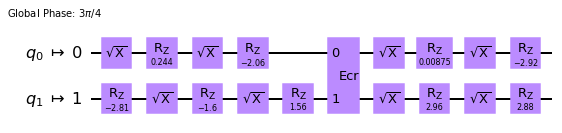

In [47]:
from qiskit import transpile

transpiled_circ = transpile(opt_circ_sf1, sf1_backend); transpiled_circ.draw(output="mpl")

In [48]:
transpiled_circ.calibrations.keys()

dict_keys(['sx', 'ecr'])

Exact solution

In [50]:
from qiskit.algorithms import NumPyMinimumEigensolver

np_solver = NumPyMinimumEigensolver()
np_groundstate_solver = GroundStateEigensolver(qubit_converter, np_solver)

np_result = np_groundstate_solver.solve(es_problem)

target_energy = np.real(np_result.eigenenergies + np_result.nuclear_repulsion_energy)[0]
print('Energy:', target_energy)

Energy: -1.1373060357534013


Richardson extrapolation

In [51]:
get_ek = lambda res: np.real(res.eigenenergies + res.nuclear_repulsion_energy)[0]
cs = [2, -1]

extrapolate_energy = cs[0] * get_ek(res_sf1) + cs[1] * get_ek(res_sf2)
print('Energy:', extrapolate_energy)

Energy: -1.1029915301210647


Raw result

In [52]:
print(res_sf1)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.806276969873
  - computed part:      -1.806276969873
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.086307975424
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.147 S^2: 0.169 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  2.66548606]
    - computed part:      [0.0  0.0  2.66548606]
  > Dipole moment (a.u.): [0.0  0.0  -1.27653736]  Total: 1.27653736
                 (debye): [0.0  0.0  -3.24463402]  Total: 3.24463402
 


In [53]:
print(res_sf2)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.789593415176
  - computed part:      -1.789593415176
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.069624420727
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.131 S^2: 0.148 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  2.57093086]
    - computed part:      [0.0  0.0  2.57093086]
  > Dipole moment (a.u.): [0.0  0.0  -1.18198216]  Total: 1.18198216
                 (debye): [0.0  0.0  -3.00429869]  Total: 3.00429869
 


In [54]:
import pickle

In [55]:
with open("res_sf1.pk", "wb") as fp:
    pickle.dump(res_sf1, fp)

with open("res_sf2.pk", "wb") as fp:
    pickle.dump(res_sf2, fp)